# emcee hammer sampler logistic example
This example demonstrates how to use the emcee hammer MCMC sampler [1] to sample from the posterior of the logistic model. This sampler evolves multiple 'walkers' in parallel, where the position of the Kth walker is based on the position of the (K-1) walkers in the complementary ensemble.

Here we wrap the implementation of the sampler by the paper author's (see http://dfm.io/emcee/current/) in a Pints module so that it works out of the box with Pints functionality.

[1] "emcee: The MCMC Hammer", Daniel Foreman-Mackey, David W. Hogg, Dustin Lang, Jonathan Goodman, https://arxiv.org/abs/1202.3665.

## Create fake data

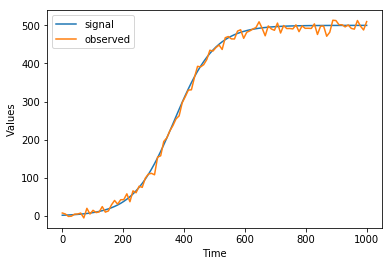

In [1]:
import sys
import os
cwd = os.getcwd()
sys.path.append('C://Users//bclamber//Documents//GitHub//pints')
import pints
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = pints.noise.add_independent_noise(signal_values,sigma)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

## Setup emcee MCMC object

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)
real_parameters = np.array(real_parameters + [sigma])

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, sigma*0.1],
    [0.02, 600, sigma*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_posterior = pints.LogPosterior(prior, log_likelihood)

# Create an emcee MCMC routine starting at true parameter values
x0 = real_parameters
mcmc = pints.EmceeHammerMCMC(log_posterior, x0)

# Set number of walkers
mcmc.set_walkers(10)

## Run emcee MCMC algorithm

In [3]:
# Run!
print('Running...')
samples_run = mcmc.run()
print('Done!')

Running...
Running emcee hammer MCMC
Total number of iterations per walker: 6000
Number of walkers: 10
Number of iterations to discard as burn-in: 3000
Storing 1 sample per 1 iteration
Done!


## Plot posterior samples

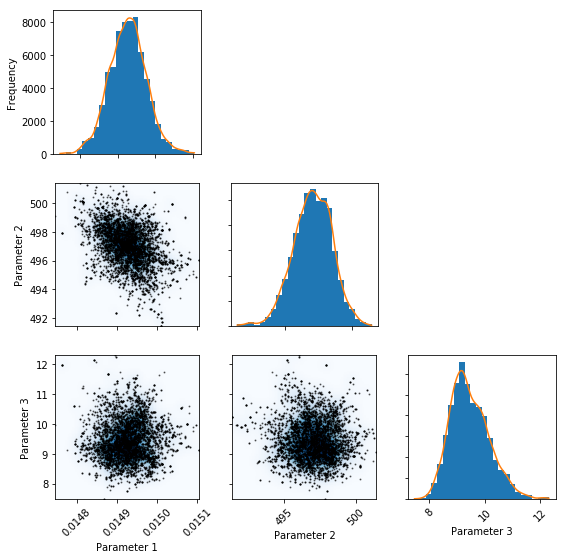

In [4]:
# Flatten across all chains
samples = samples_run.reshape((-1, 3))

## plot subset
samples = samples[1:5000,:]

# Plot output
import pints.plot # Use Pints' diagnostic tool

pints.plot.pairwise(samples, kde=True)

plt.show()

## Diagnostics

In [5]:
import pints._diagnostics as diagnostics

diagnostics.effective_sample_size(samples)

array([ 102.19848411,  128.82402848,  108.54521057])

## Same model and data but using emcee software's parallel tempering sampler

In [6]:
# Create an emcee MCMC routine starting at true parameter values
x0 = real_parameters
mcmc = pints.EmceePTMCMC(log_posterior, x0)

# Set number of walkers
mcmc.set_walkers(10)

# Run!
print('Running...')
samples_run = mcmc.run()
print('Done!')

Running...
Running emcee hammer MCMC
Total number of iterations per walker: 6000
Number of temperatures: 20
Number of walkers: 10
Number of iterations to discard as burn-in: 3000
Storing 1 sample per 1 iteration
Done!


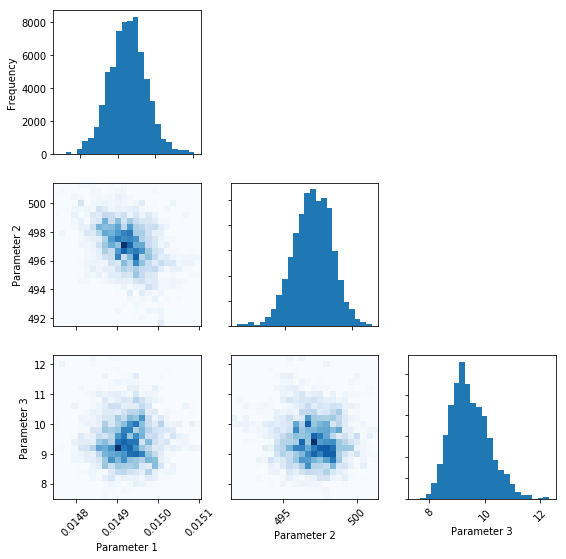

In [9]:
# Flatten across all chains
samples = samples.reshape((-1, 3))

# Plot output
import pints.plot # Use Pints' diagnostic tool

pints.plot.pairwise(samples, kde=False)

plt.show()

In [10]:
import pints._diagnostics as diagnostics

diagnostics.effective_sample_size(samples)

array([ 102.19848411,  128.82402848,  108.54521057])